> 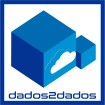 Desafio Dados2Dados: Consumindo API de tempo e temperatura com Python e SQL

https://colab.research.google.com/gist/ricosuhete/6b97ce298620912687fc985892a52144/api_openweathermap.ipynb


## Nota Importante

Este projeto aborda um desafio específico de obtenção de dados climáticos da API openweathermap, no entanto, é importante observar o seguinte:

- Foi instalado o Apache Airflow numa VM WSL usando o docker-compose e criando uma imagem personalizada;

- Para solucionar problemas técnicos, foram criadas duas DAGs no Apache Airflow. Uma DAG é executada diariamente para coletar dados climáticos atuais, enquanto a outra é executada a cada 5 dias para coletar previsões do tempo para os próximos cinco dias.

- Ambas as DAGs coletam dados para as cidades de Curitiba, Pinhais, Colombo e Londrina, localizadas no estado do Paraná, Brasil.

- Os dados coletados são armazenados em formato Delta Lake, em um bucket chamado "desafiotempo", com diferentes caminhos: "transient/daily_historic" para dados atuais e "transient/forecast_historic" para previsões futuras.

É importante destacar que, no momento, o histórico de dados disponíveis não abrange um período de 30 dias completos. Portanto, os resultados obtidos com a execução do código podem não atender às expectativas em relação a um intervalo de 30 dias. No entanto, à medida que mais dados históricos são coletados, será possível executar o código com um período de 30 dias e obter resultados mais precisos.

> #### RESOLUÇÃO:

Importando bibliotecas e definido váriveis:

In [2]:
%pip install python_dotenv

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importa as bibliotecas necessárias
print("Importando as bibliotecas necessárias")
import os
from pyspark.sql import SparkSession, Row
#from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, StringType, DateType, LongType, DoubleType, MapType
from pyspark.sql.functions import col, explode, from_unixtime, max, min, avg, round, to_date
import pyspark.sql.functions as F
import requests
import json
from pyspark import SparkConf
from datetime import datetime, timedelta
from dotenv import load_dotenv
import pandas as pd

load_dotenv("/home/jovyan/work/desafiotempo/.env") #insira o caminho do arquivo .env caso use o kernel remoto, caso contrário deixe sem parâmetro
API_KEY = os.getenv("API_KEY")

# Configura a variável de ambiente PYSPARK_SUBMIT_ARGS
print("Configurando a variável de ambiente PYSPARK_SUBMIT_ARGS")
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.hadoop:hadoop-aws:3.3.1,io.delta:delta-spark_2.12:3.0.0 --conf "spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension" --conf "spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog" pyspark-shell'
# Inicia uma sessão Spark
print("Inicando sessão spark")
spark = SparkSession.builder.appName("desafio").getOrCreate()
# Configura as configurações do MinIO (caso não estejam definidas em PYSPARK_SUBMIT_ARGS)
print("Configurando as configurações do MinIO")
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", "qiBoC6oxvaAdlFCR9I9p")
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "vjHjYMCp6fbWyHjO3iFHewSggT0lWiCBFNGVKiu2")
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "http://localhost:9001")
spark.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true")

Importando as bibliotecas necessárias
Configurando a variável de ambiente PYSPARK_SUBMIT_ARGS
Inicando sessão spark
Configurando as configurações do MinIO


Função para mapear as informações da API

In [6]:
def api_forecast(city):    
    url_tempo = f"https://api.openweathermap.org/data/2.5/forecast?q={city},PR,BR&appid={API_KEY}&units=metric&lang=pt_br"
    response = requests.get(url_tempo)
    if response.status_code == 200:
        data = response.json()
        # Cria um RDD a partir do JSON
        rdd = spark.sparkContext.parallelize([data], numSlices=1)
        # Passa o RDD para o método spark.read.json()
        df = spark.read.json(rdd, multiLine=True)
        df_flat = df.withColumn("list_explode", explode('list'))\
            .withColumn("dt_txt", col('list_explode.dt_txt'))\
            .withColumn("dt", col('list_explode.dt'))\
            .withColumn("feels_like", col('list_explode.main.feels_like'))\
            .withColumn("grnd_level", col('list_explode.main.grnd_level'))\
            .withColumn("humidity", col('list_explode.main.humidity'))\
            .withColumn("pressure", col('list_explode.main.pressure'))\
            .withColumn("sea_level", col('list_explode.main.sea_level'))\
            .withColumn("temp", col('list_explode.main.temp'))\
            .withColumn("temp_kf", col('list_explode.main.temp_kf'))\
            .withColumn("temp_max", col('list_explode.main.temp_max'))\
            .withColumn("temp_min", col('list_explode.main.temp_min'))\
            .withColumn("pop", col('list_explode.pop'))\
            .withColumn("rain", col('list_explode.rain'))\
            .withColumn("sys_pod", col('list_explode.sys.pod'))\
            .withColumn("visibility", col('list_explode.visibility'))\
            .withColumn("clouds", col('list_explode.clouds.all'))\
            .withColumn("deg", col('list_explode.wind.deg'))\
            .withColumn("gust", col('list_explode.wind.gust'))\
            .withColumn("speed", col('list_explode.wind.speed'))\
            .withColumn("weather_explode", explode('list_explode.weather'))\
            .withColumn("description", col('weather_explode.description'))\
            .withColumn("icon", col('weather_explode.icon'))\
            .withColumn("id", col('weather_explode.id'))\
            .withColumn("main", col('weather_explode.main'))\
            .drop("weather_explode")\
            .drop("list_explode")\
            .withColumn("coord", col("city.coord"))\
            .withColumn("country", col("city.country"))\
            .withColumn("city_id", col("city.id"))\
            .withColumn("name", col("city.name"))\
            .withColumn("population", col("city.population"))\
            .withColumn("sunrise", col("city.sunrise"))\
            .withColumn("sunset", col("city.sunset"))\
            .withColumn("timezone", col("city.timezone"))\
            .drop("city")\
            .drop("list")        
        return df_flat

    else:
        print(f"INFO: {response.text}")
        return None

In [8]:
def request_json(city):
    url_tempo = f"https://api.openweathermap.org/data/2.5/weather?q={city},PR,BR&appid={API_KEY}&units=metric&lang=pt_br"
    response = requests.get(url_tempo)
    if response.status_code == 200:
        data1 = response.json()
        rdd = spark.sparkContext.parallelize([data1], numSlices=1)
        # Passa o RDD para o método spark.read.json()
        df_city_temp = spark.read.json(rdd, multiLine=True)
        #df_city_temp.printSchema()

        df_flat = df_city_temp.withColumn("name", col('name'))\
                                    .withColumn("temp", col('main.temp'))\
                                    .withColumn("temp_max", col('main.temp_max'))\
                                    .withColumn("temp_min", col('main.temp_min'))\
                                    .withColumn("clouds", col('clouds.all'))\
                                    .withColumn("cod", col('cod'))\
                                    .withColumn("dt", from_unixtime(col('dt')))\
                                    .withColumn("timezone", col('timezone'))\
                                    .withColumn("main_feels_like", col('main.feels_like'))\
                                    .withColumn("humidity", col('main.humidity'))\
                                    .withColumn("pressure", col('main.pressure'))\
                                    .withColumn("country", col('sys.country'))\
                                    .withColumn("sys_id", col('sys.id'))\
                                    .withColumn("sunrise", col('sys.sunrise'))\
                                    .withColumn("sunset", col('sys.sunset'))\
                                    .withColumn("deg", col('wind.deg'))\
                                    .withColumn("speed", col('wind.speed'))\
                                    .withColumn("weather_explode", explode('weather'))\
                                    .withColumn("id", col('id'))\
                                    .withColumn("main", col('weather_explode.main'))\
                                    .withColumn("icon", col('weather_explode.icon'))\
                                    .withColumn("weather_id", col('weather_explode.id'))\
                                    .drop("weather_explode")\
                                    .drop("sys")\
                                    .drop("weather")\
                                    .drop("wind")\
                                    .drop("base")
        return df_flat
    else:
        print(f"INFO:{response.text}")
        return {}

#### - Obter a temperatura atual para uma lista de cidades do seu estado e armazenar os resultados em uma tabela SQL.

In [9]:
list_city_name = ["curitiba", "pinhais", "colombo", "londrina"]
for city in list_city_name:    
    df_city_temp = request_json(city)
    df_city_temp = df_city_temp.select("name", "dt", "temp", "temp_max", "temp_min", "main")
    df_city_temp.show()

+--------+-------------------+-----+--------+--------+------+
|    name|                 dt| temp|temp_max|temp_min|  main|
+--------+-------------------+-----+--------+--------+------+
|Curitiba|2023-11-08 04:46:04|14.27|   14.47|   13.93|Clouds|
+--------+-------------------+-----+--------+--------+------+

+-------+-------------------+-----+--------+--------+------+
|   name|                 dt| temp|temp_max|temp_min|  main|
+-------+-------------------+-----+--------+--------+------+
|Pinhais|2023-11-08 04:46:08|14.32|   14.64|    14.1|Clouds|
+-------+-------------------+-----+--------+--------+------+

+-------+-------------------+-----+--------+--------+------+
|   name|                 dt| temp|temp_max|temp_min|  main|
+-------+-------------------+-----+--------+--------+------+
|Colombo|2023-11-08 04:42:29|13.43|    13.9|   13.36|Clouds|
+-------+-------------------+-----+--------+--------+------+

+--------+-------------------+-----+--------+--------+-----+
|    name|      

#### - Analisar a temperatura máxima e mínima para cada cidade em um período de 30 dias e exibir os resultados em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [35]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"
#lendo o delta
df_temp = spark.read.format(format).load(table_path)
df_temp = df_temp.select("name", "temp_max", "temp_min", "dt")


df_temp = df_temp.withColumn("date", from_unixtime(col("dt")))

# Defina a data de início e fim do intervalo de 30 dias
data_inicio = "2023-10-31"
data_fim = "2023-11-30"

# Selecione o intervalo de 30 dias
df_temp = df_temp.filter((col("date") >= data_inicio) & (col("date") <= data_fim))

# Calcular a média da coluna "temp_max"
average_temp_max = df_temp.groupBy("name").agg(avg("temp_max").alias("media_temp_max"))
average_temp_max = average_temp_max.withColumnRenamed("name", "Cidade")
# Calcular a média da coluna "temp_min"
average_temp_min = df_temp.groupBy("name").agg(avg("temp_min").alias("media_temp_min"))
average_temp_min = average_temp_min.withColumnRenamed("name", "Cidade")

# Encontrar a cidade com a maior média de temperatura máxima
city_with_max_temp_max = average_temp_max.orderBy(col("media_temp_max").desc()).first()

# Encontrar a cidade com a menor média de temperatura mínima
city_with_min_temp_min = average_temp_min.orderBy(col("media_temp_min").asc()).first()

# Criar DataFrames para as cidades com a maior e a menor média de temperatura:
city_with_max_temp_max = spark.createDataFrame([Row(**city_with_max_temp_max.asDict())])
city_with_min_temp_min = spark.createDataFrame([Row(**city_with_min_temp_min.asDict())])


city_with_max_temp_max.createOrReplaceTempView("city_with_max_temp_max")
city_with_min_temp_min.createOrReplaceTempView("city_with_min_temp_min")
spark.sql("SELECT * FROM city_with_max_temp_max, city_with_min_temp_min").show()

+--------+--------------+-------+------------------+
|  Cidade|media_temp_max| Cidade|    media_temp_min|
+--------+--------------+-------+------------------+
|Londrina|      20.47325|Colombo|16.086750000000002|
+--------+--------------+-------+------------------+



#### - Determinar a cidade com a maior diferença entre a temperatura máxima e mínima e exibir o resultado em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [36]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"
#lendo o delta
df_temp = spark.read.format(format).load(table_path)
df_temp = df_temp.select("name", "temp_max", "temp_min", "dt_txt")
# Calcular a diferença entre a temperatura máxima e mínima
df_temp = df_temp.withColumn("diferença_temp", col("temp_max") - col("temp_min"))

# Encontrar a cidade com a maior diferença
city_with_max_temp_diff = df_temp.orderBy(col("diferença_temp").desc()).first()

# Criar um DataFrame para a cidade com a maior diferença
max_temp_diff_df = spark.createDataFrame([Row(**city_with_max_temp_diff.asDict())])

# Exibir a cidade com a maior diferença em uma tabela SQL
max_temp_diff_df.createOrReplaceTempView("max_temp_diff_city")
spark.sql("SELECT * FROM max_temp_diff_city").show()

+--------+--------+--------+-------------------+------------------+
|    name|temp_max|temp_min|             dt_txt|    diferença_temp|
+--------+--------+--------+-------------------+------------------+
|Curitiba|   21.27|   19.25|2023-10-31 12:00:00|2.0199999999999996|
+--------+--------+--------+-------------------+------------------+



#### - Identificar a cidade mais quente e a cidade mais fria em um período de 30 dias e exibir os resultados em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [37]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"
#lendo o delta
df_temp2 = spark.read.format(format).load(table_path)
df_temp2 = df_temp2.select("name", "temp", "dt")

df_temp2 = df_temp2.withColumn("date", from_unixtime(col("dt")))

# Defina a data de início e fim do intervalo de 30 dias
data_inicio = "2023-10-31"
data_fim = "2023-11-30"

# Seleciona o intervalo de 30 dias
df_temp2 = df_temp2.filter((col("date") >= data_inicio) & (col("date") <= data_fim))

# Calcular a média da coluna "temp"
average_temp = df_temp2.groupBy("name").agg(avg("temp").alias("temp"))
average_temp = average_temp.withColumnRenamed("name", "Cidade")

# Arredondar a coluna "temp" para duas casas decimais
average_temp = average_temp.withColumn("temp", round(average_temp["temp"], 2))

# Encontrar a cidade com a maior média de temperatura
city_with_max_temp = average_temp.orderBy(col("temp").desc()).first()
city_with_max_temp = spark.createDataFrame([Row(**city_with_max_temp.asDict())])
city_with_max_temp.createOrReplaceTempView("city_with_max_temp")

# Encontrar a cidade com a menor média de temperatura
city_with_min_temp = average_temp.orderBy(col("temp").asc()).first()
city_with_min_temp = spark.createDataFrame([Row(**city_with_min_temp.asDict())])
city_with_min_temp.createOrReplaceTempView("city_with_min_temp")

# Criar tabela SQL para as cidades com a maior e a menor média de temperatura:
print("Cidades com a maior e a menor média de temperatura:")
spark.sql("SELECT * FROM city_with_max_temp, city_with_min_temp").show() 

Cidades com a maior e a menor média de temperatura:
+--------+-----+-------+----+
|  Cidade| temp| Cidade|temp|
+--------+-----+-------+----+
|Londrina|20.47|Colombo|16.1|
+--------+-----+-------+----+



#### - Calcular a média da temperatura para cada dia em um período de 30 dias e exibir os resultados em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [38]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"

# Carregue os dados Delta Lake
df_temp3 = spark.read.format(format).load(table_path)

# Converter a coluna "dt_txt" para o nível do dia
df_temp3 = df_temp3.withColumn("date", to_date(df_temp3["dt_txt"]))

# Calcule a média da temperatura diária
average_temp3 = df_temp3.groupBy("name", "date").agg(avg("temp").alias("daily_avg_temp"))

# Arredonde a coluna "daily_avg_temp" para duas casas decimais
average_temp3 = average_temp3.withColumn("daily_avg_temp", round(average_temp3["daily_avg_temp"], 2))

# Crie uma tabela temporária
average_temp3.createOrReplaceTempView("daily_avg_temp_table")

spark.sql("""SELECT name, date, daily_avg_temp FROM daily_avg_temp_table
WHERE date BETWEEN '2023-10-31' AND '2023-11-30' ORDER BY name ASC, date ASC""").show(400)

+--------+----------+--------------+
|    name|      date|daily_avg_temp|
+--------+----------+--------------+
| Colombo|2023-10-31|         18.14|
| Colombo|2023-11-01|          16.0|
| Colombo|2023-11-02|         15.86|
| Colombo|2023-11-03|         17.63|
| Colombo|2023-11-04|         15.38|
| Colombo|2023-11-05|         11.45|
|Curitiba|2023-10-31|         18.99|
|Curitiba|2023-11-01|         16.55|
|Curitiba|2023-11-02|         16.36|
|Curitiba|2023-11-03|         17.83|
|Curitiba|2023-11-04|         15.62|
|Curitiba|2023-11-05|         12.34|
|Londrina|2023-10-31|         20.36|
|Londrina|2023-11-01|         20.52|
|Londrina|2023-11-02|          21.4|
|Londrina|2023-11-03|         22.98|
|Londrina|2023-11-04|         19.05|
|Londrina|2023-11-05|          15.2|
| Pinhais|2023-10-31|         19.11|
| Pinhais|2023-11-01|         16.51|
| Pinhais|2023-11-02|         16.33|
| Pinhais|2023-11-03|          18.0|
| Pinhais|2023-11-04|         15.93|
| Pinhais|2023-11-05|         12.38|
+

#### - Identificar as cidades com as maiores e menores variações de temperatura em um período de 30 dias e exibir os resultados em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [39]:
# Inicialize a sessão Spark
spark = SparkSession.builder.appName("Variação de Temperatura").getOrCreate()

# Carregue os dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"
table_path = f"s3a://{minio_bucket_name}/{minio_path}"
df_temp4 = spark.read.format(format).load(table_path)
df_temp4 = df_temp4.select("name", "temp_max", "temp_min", "dt")

df_temp4 = df_temp4.withColumn("date", from_unixtime(col("dt")))

# Defina a data de início e fim do intervalo de 30 dias
data_inicio = "2023-10-31"
data_fim = "2023-11-30"

# Selecione o intervalo de 30 dias
df_temp4 = df_temp4.filter((col("date") >= data_inicio) & (col("date") <= data_fim))

# Agregar as médias de temp_max e temp_min para cada cidade
df_temp4 = df_temp4.groupBy("name").agg(avg(col("temp_max")).alias("media_temp_max"), avg(col("temp_min")).alias("media_temp_min"))

# Calcular a diferença entre a temperatura máxima e mínima
df_temp4 = df_temp4.withColumn("diferença_temp", col("media_temp_max") - col("media_temp_min"))
df_temp4 = df_temp4.withColumn("dif_temp", round(col("diferença_temp"), 3))
# Encontra a cidade com a maior diferença de temperatura
city_with_max_temp_diff = df_temp4.orderBy(col("dif_temp").desc()).first()

# Encontra a cidade com a menor diferença de temperatura
city_with_min_temp_diff = df_temp4.orderBy(col("dif_temp")).first()

# Exibir os resultados em uma tabela SQL
results_df = spark.createDataFrame([city_with_max_temp_diff, city_with_min_temp_diff])
results_df.createOrReplaceTempView("variacoes_temperatura")
spark.sql("SELECT name, dif_temp  FROM variacoes_temperatura").show()

# Encerre a sessão Spark
spark.stop()

+--------+--------+
|    name|dif_temp|
+--------+--------+
|Curitiba|   0.081|
| Colombo|   0.056|
+--------+--------+



#### - Obter a previsão do tempo para uma lista de cidades do seu estado nos próximos 7 dias e armazenar os resultados em uma tabela SQL.

In [40]:
# Inicialize a sessão Spark
spark = SparkSession.builder.appName("Exemplo").getOrCreate()

list_city_name = ["curitiba", "pinhais", "colombo", "londrina"]

# Crie uma lista de DataFrames para cada cidade
dfs = []
for city in list_city_name:
    df = api_forecast(city)
    df = df.withColumn("date", from_unixtime(col("dt")))

    # Defina a data de início e fim do intervalo de 30 dias
    now = datetime.now()
    day = timedelta(days=1)
    data_inicio = now
    data_fim = now + 7 * day

    # Selecione o intervalo de 30 dias
    df = df.filter((col("date") >= data_inicio) & (col("date") <= data_fim))
    df.createOrReplaceTempView(f"forecast{city}")
    dfs.append(df)

# Combine os DataFrames de todas as cidades usando union
combined_df = dfs[0]
for df in dfs[1:]:
    combined_df = combined_df.union(df)


combined_df= combined_df.select("name", "temp", "main", "date")
# Exiba os resultados
combined_df.orderBy("name", "date").show(200)

+--------+-----+------+-------------------+
|    name| temp|  main|               date|
+--------+-----+------+-------------------+
| Colombo|15.58|  Rain|2023-11-01 06:00:00|
| Colombo|15.46|  Rain|2023-11-01 09:00:00|
| Colombo|16.72|Clouds|2023-11-01 12:00:00|
| Colombo|20.33|  Rain|2023-11-01 15:00:00|
| Colombo|18.44|Clouds|2023-11-01 18:00:00|
| Colombo|15.39|Clouds|2023-11-01 21:00:00|
| Colombo|13.84|Clouds|2023-11-02 00:00:00|
| Colombo|13.65|Clouds|2023-11-02 03:00:00|
| Colombo|13.68|Clouds|2023-11-02 06:00:00|
| Colombo|13.84|Clouds|2023-11-02 09:00:00|
| Colombo|15.98|  Rain|2023-11-02 12:00:00|
| Colombo|21.36|Clouds|2023-11-02 15:00:00|
| Colombo|17.04|  Rain|2023-11-02 18:00:00|
| Colombo|16.45|  Rain|2023-11-02 21:00:00|
| Colombo|15.39|Clouds|2023-11-03 00:00:00|
| Colombo| 15.0|  Rain|2023-11-03 03:00:00|
| Colombo|14.73|  Rain|2023-11-03 06:00:00|
| Colombo|14.64|  Rain|2023-11-03 09:00:00|
| Colombo|19.01|  Rain|2023-11-03 12:00:00|
| Colombo|24.46|  Rain|2023-11-0

#### - Identificar a cidade com a maior quantidade de dias chuvosos em um período de 30 dias e exibir o resultado em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [41]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"

# Carregue os dados Delta Lake
df_rain = spark.read.format(format).load(table_path)
df_rain = df_rain.select("name", "main", "dt")

df_rain = df_rain.withColumn("date", from_unixtime(col("dt")))

# Defina a data de início e fim do intervalo de 30 dias
data_inicio = "2023-10-31"
data_fim = "2023-11-30"

# Selecione o intervalo de 30 dias
df_rain = df_rain.filter((col("date") >= data_inicio) & (col("date") <= data_fim))

df_rain = df_rain.filter(col("main") == "Rain") \
    .groupBy("name") \
    .count()

df_rain = df_rain.createOrReplaceTempView("avg_days_rain")

print("Rank das cidades com a maior quantidade de dias chuvosos:")
spark.sql("SELECT * FROM avg_days_rain").show()

Rank das cidades com a maior quantidade de dias chuvosos:
+--------+-----+
|    name|count|
+--------+-----+
|Curitiba|   21|
|Londrina|   15|
| Pinhais|   21|
| Colombo|   22|
+--------+-----+



#### - Calcular a média de umidade para cada dia em um período de 30 dias e exibir os resultados em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [50]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"

# Carregue os dados Delta Lake
df3 = spark.read.format(format).load(table_path)

# Converter a coluna "dt_txt" para o nível do dia
df3 = df3.withColumn("date", to_date(df3["dt_txt"]))

# Calcule a média da umidade diária
average4 = df3.groupBy("name", "date").agg(avg("humidity").alias("daily_avg_humidity"))

# Arredonde a coluna "daily_avg_humidity" para duas casas decimais
average4 = average4.withColumn("daily_avg_humidity", round(average4["daily_avg_humidity"], 2))

# Crie uma tabela temporária
average4.createOrReplaceTempView("daily_avg_humidity_table")

spark.sql("""SELECT name, date, daily_avg_humidity FROM daily_avg_humidity_table
WHERE date BETWEEN '2023-10-31' AND '2023-11-06' ORDER BY name ASC, date ASC""").show(400)

+--------+----------+------------------+
|    name|      date|daily_avg_humidity|
+--------+----------+------------------+
| Colombo|2023-10-31|              95.6|
| Colombo|2023-11-01|             94.25|
| Colombo|2023-11-02|              90.0|
| Colombo|2023-11-03|             93.88|
| Colombo|2023-11-04|              70.0|
| Colombo|2023-11-05|             85.33|
|Curitiba|2023-10-31|              93.8|
|Curitiba|2023-11-01|             93.25|
|Curitiba|2023-11-02|             89.38|
|Curitiba|2023-11-03|             93.88|
|Curitiba|2023-11-04|              69.5|
|Curitiba|2023-11-05|             81.33|
|Londrina|2023-10-31|              92.2|
|Londrina|2023-11-01|              86.5|
|Londrina|2023-11-02|             78.75|
|Londrina|2023-11-03|             79.13|
|Londrina|2023-11-04|             62.38|
|Londrina|2023-11-05|              75.0|
| Pinhais|2023-10-31|              95.0|
| Pinhais|2023-11-01|              94.5|
| Pinhais|2023-11-02|             91.13|
| Pinhais|2023-1

#### - Identificar as cidades com a maior e menor umidade média em um período de 30 dias e exibir os resultados em uma tabela SQL.

> - Para atender este item, estou acessando os dados que estão sendo salvos para compor o historico de tempo.

In [51]:
# Especifique o caminho dos dados Delta
minio_bucket_name = "desafiotempo"
minio_path = "transient/forecast_historic"
format = "delta"

table_path = f"s3a://{minio_bucket_name}/{minio_path}"
#lendo o delta
df_temp2 = spark.read.format(format).load(table_path)
df_temp2 = df_temp2.select("name", "humidity", "dt")

df_temp2 = df_temp2.withColumn("date", from_unixtime(col("dt")))

# Defina a data de início e fim do intervalo de 30 dias
data_inicio = "2023-10-31"
data_fim = "2023-11-30"

# Seleciona o intervalo de 30 dias
df_temp2 = df_temp2.filter((col("date") >= data_inicio) & (col("date") <= data_fim))

# Calcula a média da coluna "humidity"
average_temp = df_temp2.groupBy("name").agg(avg("humidity").alias("humidity"))
average_temp = average_temp.withColumnRenamed("name", "Cidade")

# Arredonda a coluna "humidity" para duas casas decimais
average_temp = average_temp.withColumn("humidity", round(average_temp["humidity"], 2))

# Encontra a cidade com a maior média de Umidade
city_with_max_temp = average_temp.orderBy(col("humidity").desc()).first()
city_with_max_temp = spark.createDataFrame([Row(**city_with_max_temp.asDict())])
city_with_max_temp.createOrReplaceTempView("city_with_max_humidity")

# Encontra a cidade com a menor média de Umidade
city_with_min_temp = average_temp.orderBy(col("humidity").asc()).first()
city_with_min_temp = spark.createDataFrame([Row(**city_with_min_temp.asDict())])
city_with_min_temp.createOrReplaceTempView("city_with_min_humidity")

# Criar tabela SQL para as cidades com a maior e a menor média de Umidade:
print("Cidades com a maior e a menor média de Umidade:")
spark.sql("SELECT * FROM city_with_max_humidity, city_with_min_humidity").show() 

Cidades com a maior e a menor média de Umidade:
+-------+--------+--------+--------+
| Cidade|humidity|  Cidade|humidity|
+-------+--------+--------+--------+
|Colombo|   87.98|Londrina|    78.5|
+-------+--------+--------+--------+



In [52]:
# # Encerra a sessão Spark
print("Sessão spark encerrada")
spark.stop()

Sessão spark encerrada
